In [171]:
import matplotlib.pyplot as plt
from scipy.fft import fft, fftshift, fftfreq
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import numpy as np
import os
from scipy.integrate import simpson

In [172]:
class Data:

    def __init__(self, filepath, filepath_categorized=False):
        self._filepath = filepath
        if filepath_categorized:
            self.categorize_by_cnot_type()
            self.categorize_by_state()
            self.categorize_by_P()
            self.categorize_by_molecule()
        self._center_fre = 5.2 # ppm
        self._lam_fre = 62.3751755
        self.read_data()
        self.get_time_domain_data()
        self.get_frequency_domain_data()
        self.get_peaks()

    def read_data(self):
        data = np.loadtxt(self._filepath, delimiter=',')
        self._raw_data = data
        return data

    def categorize_by_P(self):
            if "P0" in self._filepath:
                self._P = 'P0'
            elif "P1" in self._filepath:
                self._P = 'P1'
            elif "P2" in self._filepath:
                self._P = 'P2'
            else:
                print(f"File is not in P category: {self._filepath}")

    def categorize_by_state(self):
        if "00" in self._filepath:
            self._state = "00"
        elif "01" in self._filepath:
            self._state = "01"
        elif "10" in self._filepath:
            self._state = "10"
        elif "11" in self._filepath:
            self._state = "11"
        else:
            print(f"File is not in state category: {self._filepath}")

    def categorize_by_molecule(self):
        if "H" in self._filepath:
            self._molecule = "H"
        elif "C" in self._filepath:
            self._molecule = "C"
        else:
            print(f"File is not labeled H or C: {self._filepath}")

    def categorize_by_cnot_type(self):
        
        if "approx" in self._filepath:
            self._cnot_type = "approximate"
        else: 
            self._cnot_type = "real"

    def get_time_domain_data(self):
        time = self._raw_data[:, 0]  
        real_part = self._raw_data[:, 1]
        imaginary_part = self._raw_data[:, 2]
        complex_signal = real_part + 1j * imaginary_part
        self._time = time
        self._real_part = real_part
        self._imaginary_part = imaginary_part
        self._time_domain_data = complex_signal
        return (time, complex_signal)
    
    def get_frequency_domain_data(self):
        time = self._time
        N = len(time)
        dt = time[1] - time[0]
        fft_result = fft(self._time_domain_data)
        fft_result = fftshift(fft_result)
        frequencies = fftshift(fftfreq(N, dt))
        self._frequencies = frequencies
        self._fft_result = fft_result
        return (frequencies, fft_result)
    
    def get_peaks(self, n_peaks=2):
        peaks, properties = find_peaks(np.abs(self._fft_result),
                                       height=0.1 * np.max(np.abs(self._fft_result)))

        # extract peak heights and sort them by magnitude in descending order
        peak_heights = properties["peak_heights"]
        sorted_indices = np.argsort(peak_heights)[::-1]
        
        # select indices of the top n peaks
        top_indices = sorted_indices[:n_peaks]
        
        # extract the frequencies and magnitudes of the top peaks
        top_frequencies = self._frequencies[peaks[top_indices]]
        top_magnitudes = peak_heights[top_indices]

        # store the top peak frequencies and magnitudes
        self._peak_frequencies = top_frequencies.tolist()
        self._peak_magnitudes = top_magnitudes.tolist()

        return self._peak_frequencies, self._peak_magnitudes

    def fit_lorentzian(self, fit_range, peak_index):
        def lorentzian(f, f0, A, gamma,b):
            return  np.real (b+A * gamma / (1j*(f - f0) + gamma))
        
        fit_mask = (self._frequencies > (self._peak_frequencies[peak_index] - fit_range)) \
              & (self._frequencies < (self._peak_frequencies[peak_index] + fit_range))
        
        popt, pcov = curve_fit(lorentzian, self._frequencies[fit_mask], np.abs(self._fft_result)[fit_mask], 
                               p0=[self._peak_frequencies[peak_index], np.max(np.abs(self._fft_result)[fit_mask]), 0.1,0])
        
        fitted_f0, fitted_A, fitted_gamma, fitted_b = popt
        std_f0, std_A, std_gamma, std_b= np.sqrt(np.diag(pcov))

        if not hasattr(self, '_fitted_f0'):
            self._fitted_f0 = {}
        if not hasattr(self, '_fitted_A'):
            self._fitted_A = {}
        if not hasattr(self, '_fitted_gamma'):
            self._fitted_gamma = {}
        if not hasattr(self, '_fitted_b'):
            self._fitted_b = {}
        if not hasattr(self, '_std_f0'):
            self._std_f0 = {}
        if not hasattr(self, '_std_A'):
            self._std_A = {}
        if not hasattr(self, '_std_gamma'):
            self._std_gamma = {}
        if not hasattr(self, '_std_b'):
            self._std_b = {}

        self._fitted_f0[peak_index] = fitted_f0
        self._fitted_A[peak_index] = fitted_A
        self._fitted_gamma[peak_index] = fitted_gamma
        self._fitted_b[peak_index] = fitted_b

        self._std_f0[peak_index] = std_f0
        self._std_A[peak_index] = std_A
        self._std_gamma[peak_index] = std_gamma
        self._std_b[peak_index] = std_b
        lorentzian = lorentzian(self._frequencies[fit_mask], *popt)
        self._lorentzian = lorentzian

        self._popt = popt
        self._pcov = pcov
        return lorentzian
    
    def calculate_T2(self, peak_index):
        T2 = 1 / (self._fitted_gamma[peak_index])
        std_T2 = T2 * (self._std_gamma[peak_index] / self._fitted_gamma[peak_index])
        return (T2, std_T2)

    def plot_time_domain_data(self):
        plt.figure(figsize=(10, 6))
        plt.subplot(2, 1, 1)
        plt.plot(self._time, self._real_part, label='Real Part')
        plt.plot(self._time, self._imaginary_part, label='Imaginary Part', color='orange')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.title('Time Domain Signal')
        # plt.savefig('FID_on_resonance_re.png', dpi=300)  # Saves the figure as a PNG file with 300 dpi
        plt.legend()

    def plot_frequency_domain_data_one_peak(self, fit_range, peak_index):
        fit_mask = (self._frequencies > (self._peak_frequencies[peak_index] - fit_range)) \
              & (self._frequencies < (self._peak_frequencies[peak_index] + fit_range))

        plt.figure(figsize=(10, 6))
        plt.plot(self._frequencies[fit_mask] + (self._center_fre+1) 
                 * self._lam_fre*1e3, np.abs(self._fft_result)[fit_mask], 'o', 
                 label='FFT Data', markersize=4)
        
        plt.plot(self._frequencies[fit_mask] + (self._center_fre+1)
                 * self._lam_fre*1e3, 
                 self._lorentzian, label='Lorentzian Fit', color='red')
        
        plt.xlabel('Frequency (kHz)')
        plt.ylabel('Magnitude')
        plt.title(f'Lorentzian Fit Around {self._peak_frequencies[peak_index] + (self._center_fre+1) * self._lam_fre * 1e3:.2f} kHz')
        plt.legend()
        # plt.savefig('FID_1H_25us_pluse_fit.png', dpi=300)  # Saves the figure as a PNG file with 300 dpi
        plt.show()

    def plot_frequency_domain_data(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self._frequencies, self._fft_result, 'o', 
                    label='FFT Data', markersize=4)        
        plt.xlabel('Frequency (kHz)')
        plt.ylabel('Magnitude')
        plt.title(f'Frequency Domain Signal')
        plt.legend()
        # plt.savefig('FID_1H_25us_pluse_fit.png', dpi=300)  # Saves the figure as a PNG file with 300 dpi
        plt.show()
        
    def integrate_peak(self, peak_index, integration_range):
        current_peak_frequency = self._peak_frequencies[peak_index]
        lower_bound = current_peak_frequency - integration_range
        upper_bound = current_peak_frequency + integration_range
        integration_mask = (self._frequencies > lower_bound) & (self._frequencies < upper_bound)
        integrated_value = simpson(np.abs(self._fft_result[integration_mask]), self._frequencies[integration_mask])
        return integrated_value



In [173]:
# make Data objects for all files in directory and categorize
def initialize_data(directory_path):
    data = []
    for file in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file)
        if os.path.isfile(file_path):
            data_object = Data(file_path, filepath_categorized=True)
            data.append(data_object)
    categorized_data = categorize_data(data)
    return categorized_data

def categorize_data(all_data):
    categorized_data = {}
    for data in all_data:
        cnot_type = data._cnot_type
        molecule = data._molecule
        state = data._state
        P_type = data._P
        
        if cnot_type not in categorized_data:
            categorized_data[cnot_type] = {}
        if molecule not in categorized_data[cnot_type]:
            categorized_data[cnot_type][molecule] = {}
        if state not in categorized_data[cnot_type][molecule]:
            categorized_data[cnot_type][molecule][state] = {}
        if P_type in categorized_data[cnot_type][molecule][state]:
            raise ValueError(f"Error: More than one file for {cnot_type}, {molecule}, {state}, {P_type}")
        else:
            categorized_data[cnot_type][molecule][state][P_type] = data
    
    return categorized_data



/home/codespace/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/codespace/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


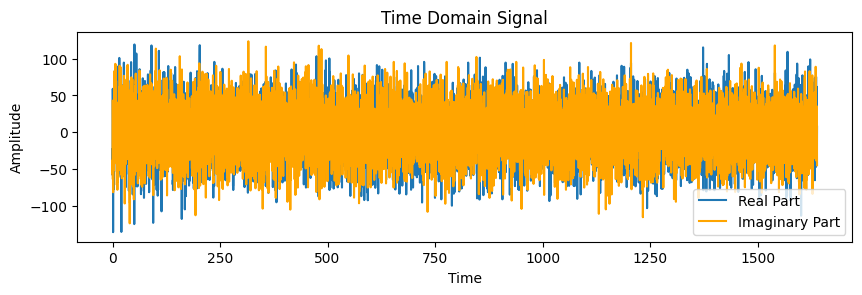

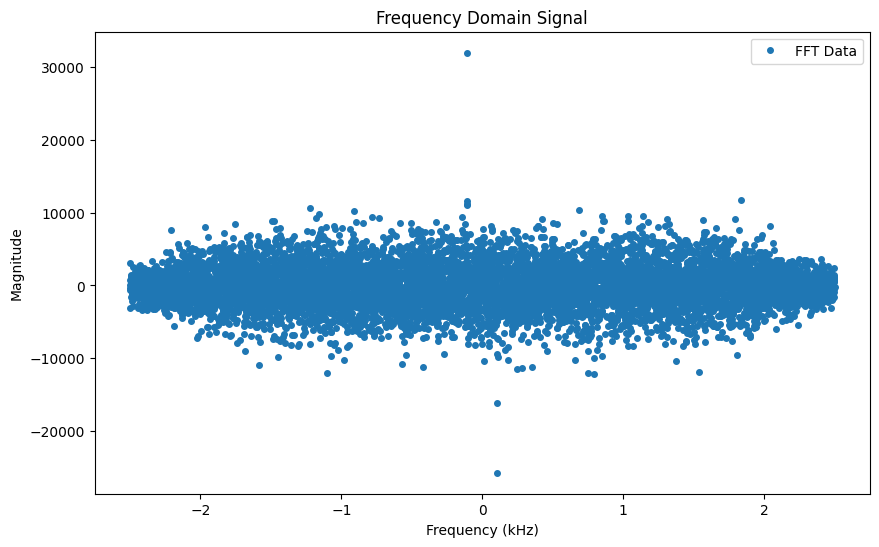

In [174]:
folder_path = "/workspaces/nmr_lab3/lab3_tt_all"
categorized_data = initialize_data(folder_path)

test_data_object = categorized_data['real']['C']['11']['P0']

test_data_object.plot_time_domain_data()

test_data_object.plot_frequency_domain_data()

# fit_range = 10
# peak_index = 0
# test_data_object.fit_lorentzian(fit_range, peak_index)
# test_data_object.plot_frequency_domain_data_one_peak(fit_range, peak_index)


In [176]:
peak1_integrals = []
peak2_integrals = []

for P,data in categorized_data['real']['C']['11'].items():
    integration_range = 10
    peak1_integrals.append(data.integrate_peak(0, integration_range))
    peak2_integrals.append(data.integrate_peak(1, integration_range))

print(peak1_integrals)
print(peak2_integrals)


[32325.013686611816, 32243.72176742033, 18386.50724470554]
[32325.013686611816, 32243.72176742033, 18386.50724470554]


/tmp/ipykernel_34105/929401483.py:200: DeprecationWarning: You are passing x=[-2.5        -2.49938965 -2.4987793  ...  2.49816895  2.4987793
  2.49938965] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  integrated_value = simpson(np.abs(self._fft_result[integration_mask]), self._frequencies[integration_mask])
